In [1]:
# check env variable
def check(VAR):
    import os

    if VAR in os.environ:
        print(f"{VAR} is set as {os.environ[VAR]}")


def checkVars(VARS):
    for VAR in VARS:
        check(VAR)


VARS = ["https_proxy", "http_proxy", "HF_ENDPOINT", "HF_HUB_ENABLE_HF_TRANSFER"]
checkVars(VARS)

https_proxy is set as http://127.0.0.1:7890
http_proxy is set as http://127.0.0.1:7890
HF_ENDPOINT is set as https://hf-mirror.com
HF_HUB_ENABLE_HF_TRANSFER is set as 0


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim import AdamW

from tqdm.notebook import tqdm

from transformers import BertModel, BertConfig, BertTokenizer

import os
import pandas as pd

In [3]:
dataDir = "/home/twh/code/mtba/asap/data"
useModel = "google-bert/bert-base-chinese"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cacheDir = "./cache/"


def get_data_path(dataFile):
    return os.path.join(dataDir, dataFile)


def get_data(dataFile):
    return pd.read_csv(get_data_path(dataFile))

In [4]:
train_sample = get_data("train_sample.csv")
# train_sample.head()
test_text = train_sample["reviewbody"][0]
print(test_text)
print(train_sample.columns)

状元楼饭店第一次去，因为地理位置优越：在宁波市和义大道高、大、上，里面装修中式，菜是地道的宁波菜，口味纯正，醉泥螺特棒，吃到了小时候的味道，因为去了晚了，在大堂等了一会儿，期间有茶水喝、服务员还与你聊天，到了就餐时生意太好，服务员都是小跑状，服务态度绝对不提速，样样都服务到位，点酒水还耐心的与我们解释，就这样绝对要夸一夸，特别是彭新星、洪继华（看服务牌才知道名字）也给我们宁波市形象增色，状元楼是宁波的一扇窗口，服务员的素质更体现我们宁波人的精神面貌。赞一个
Index(['index', 'reviewbody', 'star', 'location_traffic',
       'location_distance_from_business_district', 'location_easy_to_find',
       'service_wait_time', 'service_waiters_attitude',
       'service_parking_convenience', 'service_serving_speed', 'price_level',
       'price_cost_effective', 'price_discount', 'environment_decoration',
       'environment_noise', 'environment_space', 'environment_cleaness',
       'dish_portion', 'dish_taste', 'dish_look', 'dish_recommendation'],
      dtype='object')


In [5]:
train_set = get_data("train.csv")
print(train_set.columns)

Index(['id', 'review', 'star', 'Location#Transportation', 'Location#Downtown',
       'Location#Easy_to_find', 'Service#Queue', 'Service#Hospitality',
       'Service#Parking', 'Service#Timely', 'Price#Level',
       'Price#Cost_effective', 'Price#Discount', 'Ambience#Decoration',
       'Ambience#Noise', 'Ambience#Space', 'Ambience#Sanitary', 'Food#Portion',
       'Food#Taste', 'Food#Appearance', 'Food#Recommend'],
      dtype='object')


In [6]:
test_set = get_data("test.csv")
print(test_set.columns)

Index(['id', 'review', 'star', 'Location#Transportation', 'Location#Downtown',
       'Location#Easy_to_find', 'Service#Queue', 'Service#Hospitality',
       'Service#Parking', 'Service#Timely', 'Price#Level',
       'Price#Cost_effective', 'Price#Discount', 'Ambience#Decoration',
       'Ambience#Noise', 'Ambience#Space', 'Ambience#Sanitary', 'Food#Portion',
       'Food#Taste', 'Food#Appearance', 'Food#Recommend'],
      dtype='object')


In [7]:
tokenizer = BertTokenizer.from_pretrained(useModel)

# DataSet


In [8]:
class ReviewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_length = max_length

        # 分别提取输入文本和标签
        self.reviews = self.data["review"].tolist()
        # 提取 'star' 及之后所有列作为标签
        self.labels = self.data.loc[:, "star":].to_numpy()
        # 将 'star' 之后所有列的值加2
        self.labels[..., 1:] += 2

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        labels = self.labels[idx]

        # 使用tokenizer编码文本
        inputs = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors="pt",  # 返回PyTorch tensors格式
        )

        input_ids = inputs["input_ids"].squeeze(0)  # 去掉批次维度
        attention_mask = inputs["attention_mask"].squeeze(0)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": torch.tensor(labels, dtype=torch.float),
        }

In [9]:
# compute weights according to the distribution of the labels
def compute_weights(data=get_data("train.csv")):
    data = data.loc[:, "Location#Transportation":] + 2
    # compute value frequency for each column
    value_freq = data.apply(pd.Series.value_counts)
    # normalize the frequency
    value_freq = value_freq.div(value_freq.sum(axis=0), axis=1)
    # print(value_freq)
    # get 1/freq as pytorch tensor
    weights = torch.tensor(1 / value_freq.values, dtype=torch.float)
    return weights


weights = compute_weights().to(device)
print(weights.shape)

torch.Size([4, 18])


In [10]:
train_set = ReviewsDataset(dataframe=get_data("train.csv"), tokenizer=tokenizer)
test_set = ReviewsDataset(dataframe=get_data("test.csv"), tokenizer=tokenizer)

In [11]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

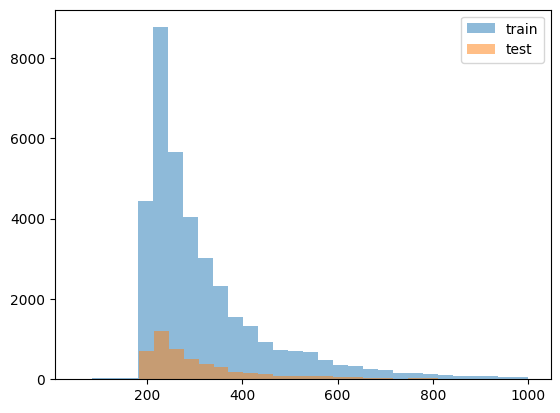

In [12]:
# plot length distribution of train set and test set
import matplotlib.pyplot as plt

train_lengths = [len(review) for review in train_set.reviews]
test_lengths = [len(review) for review in test_set.reviews]

plt.hist(train_lengths, bins=30, alpha=0.5, label="train")
plt.hist(test_lengths, bins=30, alpha=0.5, label="test")
plt.legend()

# Model


In [13]:
def print_shape(tensor):
    print(tensor.shape)


class BertForFineGrainedSentimentClassification(nn.Module):
    def __init__(
        self, num_classes_per_aspect, num_aspects, config, enjoy_weights=False
    ):
        super().__init__()
        self.num_classes_per_aspect = num_classes_per_aspect
        self.num_aspects = num_aspects
        self.enjoy_weights = enjoy_weights

        self.bert = BertModel.from_pretrained(useModel, config=config)
        for param in self.bert.parameters():
            param.requires_grad = False

        self.scorer = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.Tanh(),
            nn.Linear(config.hidden_size, 1, bias=False),
        )

        self.config = config

        if not enjoy_weights:
            self.Wa = nn.Parameter(
                torch.Tensor(num_aspects, config.hidden_size, config.hidden_size)
            )
            self.w = nn.Parameter(torch.Tensor(num_aspects, 1, config.hidden_size))
            self.Wp = nn.Parameter(
                torch.Tensor(num_aspects, config.hidden_size, config.hidden_size)
            )
            self.Wq = nn.Parameter(
                torch.Tensor(num_aspects, num_classes_per_aspect, config.hidden_size)
            )
            self.bq = nn.Parameter(torch.Tensor(num_aspects, num_classes_per_aspect, 1))
        else:
            self.aspect = nn.Sequential(
                nn.Linear(config.hidden_size, config.hidden_size),
                nn.Tanh(),
                nn.Linear(config.hidden_size, 1),
            )
            raise NotImplementedError

        self._init_weights()

    def _init_weights(self):
        """Initialize weights for custom layers and parameters"""
        # 初始化Scorer模块
        for layer in self.scorer:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

        # 初始化自定义参数
        nn.init.xavier_normal_(self.Wa)
        nn.init.xavier_normal_(self.w)
        nn.init.xavier_normal_(self.Wp)
        nn.init.xavier_normal_(self.Wq)
        nn.init.zeros_(self.bq)

    def forward(self, inputs):
        outputs = self.bert(**inputs)
        sequence_output = outputs.last_hidden_state
        # print_shape(sequence_output)
        if not self.enjoy_weights:
            sequence_output = sequence_output.transpose(1, 2)
            # print_shape(sequence_output)
            # sequence_output (batch_size, hidden_size, seq_len) ie (B,d,Z)
            Ma = torch.einsum("Ndd,BdZ->BNdZ", self.Wa, sequence_output)
            # print_shape(Ma)
            wMa = torch.einsum("Ned,BNdZ->BNeZ", self.w, Ma).transpose(2, 3)
            # print_shape(wMa)
            alpha = torch.softmax(wMa, dim=-1)
            WpH = torch.einsum("Ndd,BdZ->BNdZ", self.Wp, sequence_output)
            # print_shape(WpH)
            WpH_alpha = torch.einsum("BNdZ,BNZe->BNde", WpH, alpha)
            r = torch.tanh(WpH_alpha)
            # print_shape(r)
            Wqr = torch.einsum("NCd,BNde->BNCe", self.Wq, r)
            # print_shape(Wqr)
            # print(Wqr)
            # Wqr (B, N, C, e) bq (N, C, e)
            yhat = torch.softmax((Wqr + self.bq).squeeze(-1), dim=-1)
            # print_shape(yhat)
            # print(yhat)

        else:
            temp = self.aspect(sequence_output)
            print_shape(temp)

            yhat = None
            raise NotImplementedError

        # Get CLS embedding, which is of shape (batch_size, hidden_size) ie (B,d)
        cls_embedding = outputs.pooler_output
        # print_shape(cls_embedding)
        ghat = self.scorer(cls_embedding).squeeze(-1)
        # print_shape(ghat)

        return yhat, ghat


def loss(yhat, ghat, labels):
    # Convert labels to long and ensure the change is kept by assignment
    labels = labels.to(torch.long)  # Correction here

    # Extract score labels and aspect labels
    score_labels = labels[:, 0].float()  # Convert score labels to float for MSE Loss
    aspect_labels = labels[:, 1:]  # aspect_labels are already long now

    print_shape(aspect_labels)

    num_aspects = aspect_labels.size(1)
    # print(num_aspects)

    # Compute loss for aspect classification
    aspect_loss = 0
    for i in range(num_aspects):
        aspect_loss += nn.CrossEntropyLoss(weight=weights[:, i])(
            yhat[:, i, :], aspect_labels[:, i]
        )
    aspect_loss /= num_aspects

    # Initialize MSELoss for score regression and compute loss
    mse_loss = torch.nn.MSELoss()
    score_loss = mse_loss(
        ghat, score_labels.float()
    )  # Make sure score_labels are floats

    # Total loss is the sum of aspect and score losses
    total_loss = aspect_loss + score_loss
    return total_loss

In [14]:
config = BertConfig.from_pretrained(useModel)

model = BertForFineGrainedSentimentClassification(
    num_classes_per_aspect=4,
    num_aspects=18,
    config=config,
).to(device)

# get a batch of data
batch = next(iter(test_loader))
inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
labels = batch["labels"].to(device)
yhat, ghat = model(inputs)
loss = loss(yhat, ghat, labels)

torch.Size([64, 18])


In [27]:
# compute_metrics(yhat, ghat, labels)

tensor(356, device='cuda:0') 1152


{'aspect_accuracy': tensor(0.2416, device='cuda:0'),
 'score_rmse': tensor(2.6525, device='cuda:0', grad_fn=<SqrtBackward0>)}

# Train


In [26]:
def compute_metrics(yhat, ghat, labels):
    # Extract score labels and aspect labels
    score_labels = labels[:, 0].float()
    aspect_labels = labels[:, 1:]
    # print_shape(aspect_labels)

    # compute aspect accuracy
    aspect_labels[aspect_labels == 0] = -100
    valid_label_counts = (aspect_labels != -100).sum()
    print(valid_label_counts, 64 * 18)
    aspect_accuracy = (
        torch.argmax(yhat, dim=-1) == aspect_labels
    ).sum() / valid_label_counts

    # compute aspect accuracy, ignore
    # aspect_preds = torch.argmax(yhat, dim=-1)
    # aspect_accuracy = (aspect_preds == aspect_labels).float().mean()

    # compute score RMSE
    score_rmse = torch.sqrt(torch.mean((ghat - score_labels) ** 2))

    return {"aspect_accuracy": aspect_accuracy, "score_rmse": score_rmse}


def train(model, train_loader, criterion, epochs, load_cache=True):
    writer = SummaryWriter()

    optimizer = AdamW(model.parameters())

    if load_cache:
        if os.path.exists(os.path.join(cacheDir, "model.pth")):
            model.load_state_dict(torch.load(os.path.join(cacheDir, "model.pth")))
        if os.path.exists(os.path.join(cacheDir, "optimizer.pth")):
            optimizer.load_state_dict(
                torch.load(os.path.join(cacheDir, "optimizer.pth"))
            )

    model.train()
    global_step = 0  # 初始化全局步数
    for epoch in range(epochs):
        running_loss = 0.0
        for i, batch in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            inputs = {
                key: val.to(device) for key, val in batch.items() if key != "labels"
            }
            labels = batch["labels"].to(device)
            yhat, ghat = model(inputs)
            loss = criterion(yhat, ghat, labels)
            metrics = compute_metrics(yhat, ghat, labels)
            for key, val in metrics.items():
                writer.add_scalar(key, val.item(), global_step)  # 使用全局步数
            writer.add_scalar("batch loss", loss.item(), global_step)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            global_step += 1  # 更新全局步数

        writer.add_scalar(
            "training loss", running_loss / len(train_loader), global_step
        )  # 记录每个epoch的平均损失

        # save model and optimizer
        torch.save(model.state_dict(), os.path.join(cacheDir, "model.pth"))
        torch.save(optimizer.state_dict(), os.path.join(cacheDir, "optimizer.pth"))

    writer.flush()
    writer.close()

In [17]:
config = BertConfig.from_pretrained(useModel)

model = BertForFineGrainedSentimentClassification(
    num_classes_per_aspect=4,
    num_aspects=18,
    config=config,
).to(device)

# train(model, train_loader, loss, 10)

In [18]:
def evaluation(model, test_loader):
    model.load_state_dict(torch.load(os.path.join(cacheDir, "model_1.pth")))
    model.eval()
    for i, batch in enumerate(tqdm(test_loader)):
        inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
        labels = batch["labels"].to(device)
        yhat, ghat = model(inputs)
        metrics = compute_metrics(yhat, ghat, labels)
        if i == 0:
            all_metrics = metrics
        else:
            for key, val in metrics.items():
                all_metrics[key] += val.item()
    for key in all_metrics.keys():
        all_metrics[key] /= len(test_loader)

    return all_metrics

In [19]:
# all_metrics = evaluation(model, test_loader)

In [20]:
# all_metrics

In [21]:
# loss(yhat, ghat, batch["labels"])

In [22]:
# count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


count_parameters(model)